In [ ]:
# !pip install bootstrapped
# !pip install statsmodels

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import statsmodels as bs_stats
import scipy.stats as stats

from scipy.stats import (mannwhitneyu,
                         ttest_ind, 
                         f_oneway, 
                         shapiro,
                         levene
)
from matplotlib import gridspec
from bootstrapped import bootstrap as bs
from bootstrapped import stats_functions as bs_stats
from statsmodels.stats.power import TTestIndPower

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
large = 18; med = 16; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': med,
#           'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large}
plt.rcParams.update(params)

### Описание датасета

[Accidents in France from 2005 to 2016](https://www.kaggle.com/ahmedlahlou/accidents-in-france-from-2005-to-2016) данные содержат информацию об авариях во Франции за период с 2005 по 2016 год включительно. Всего в проекте содержится 5 файлов с данными 

* `holidays.csv`-  даты празников во Франции
* `caracteristics.csv` - даты аварий, погодные условия, тип стокновения, точное положение аварии
* `places.csv` - информация о месте аварии и обстановке вокруг
* `users.csv` - сведения о людях, попавших в аварию (возраст; место, занимаемое в авто; наличие ремня безопасности или шлема)
* `vehicles.csv` - характеристика транспорта (категория, рег номер)

Однако, после разведочного анализа я выбрал для дальнейшей работы только два файла `caracteristics.csv` и `users.csv`

### Выдвижение гипотезы

Часть с обработкой пропущенных значений лежит в ноутбуке `preview.ipynb`, здесь мне это не понадобится так как в рамках разведочного анализа удалось найти гипотезу на данных без пропусков.

In [3]:
char = pd.read_csv('data/caracteristics.csv', low_memory=False,  encoding="latin-1")
users = pd.read_csv('data/users.csv', low_memory=False, encoding="latin-1")

Посмотрим, например, на количество аварий по часам, тут опять же не совсем удобно записано время (с минутами), сделаем новую колонку где будут значения часа

In [4]:
char['hour'] = char['hrmn'].astype(str)

In [5]:
char.hour = char.hour.apply(lambda x: int(x.zfill(4)[:2]))

In [6]:
by_hours = char.groupby('hour')['Num_Acc'].count()

<Axes: title={'center': 'Распределение аварий по времени суток'}, xlabel='hour'>

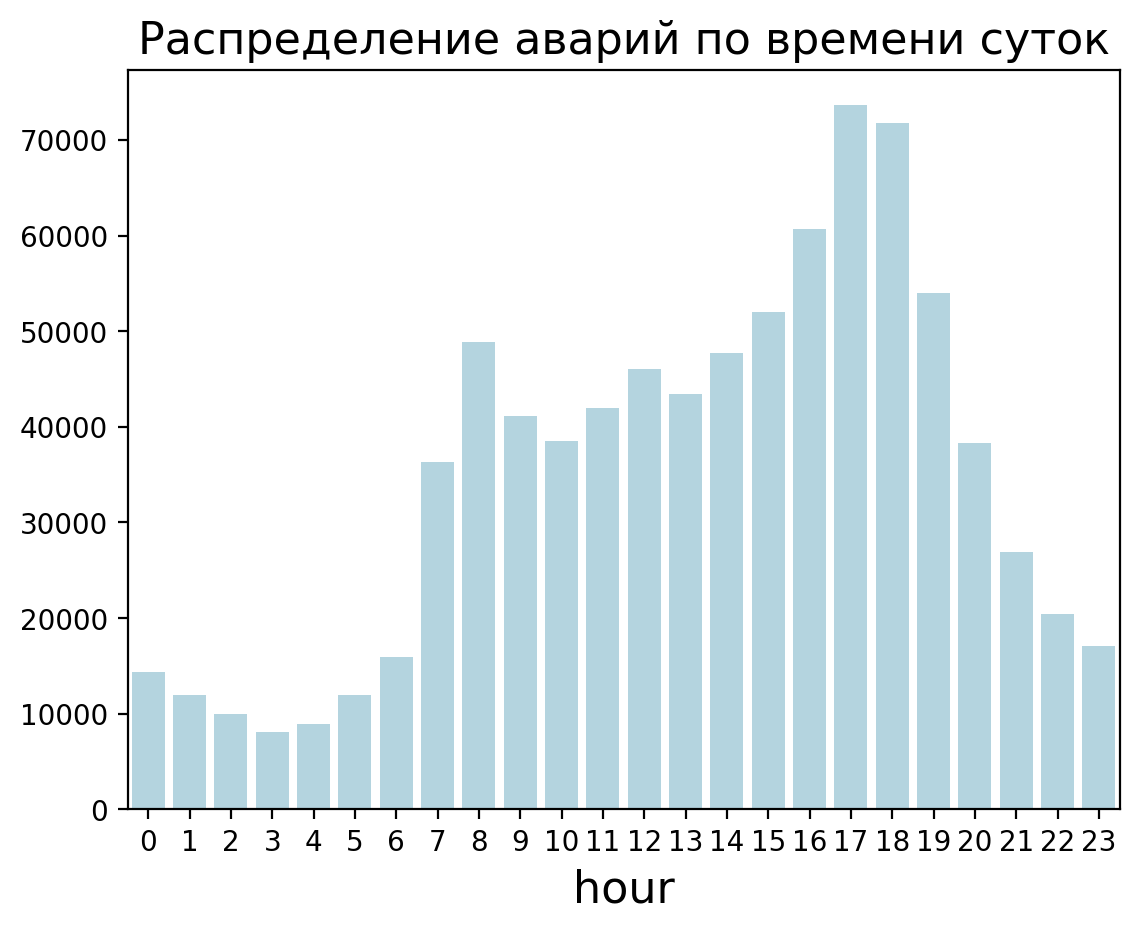

In [7]:
plt.title('Распределение аварий по времени суток')
sns.barplot(x=by_hours.index, y=by_hours.values, color='lightblue')

Видимо, большинство аварий случаются, вечером, когда люди возвращаются домой. 
Посмотрим еще на динамику аварий по годам и атмосферным условиям. Сначала по годам

In [8]:
# Переведем год в нормальный вид
char.an = char.an.apply(lambda x: x+2000)

In [9]:
year = char.groupby('an')['Num_Acc'].count()

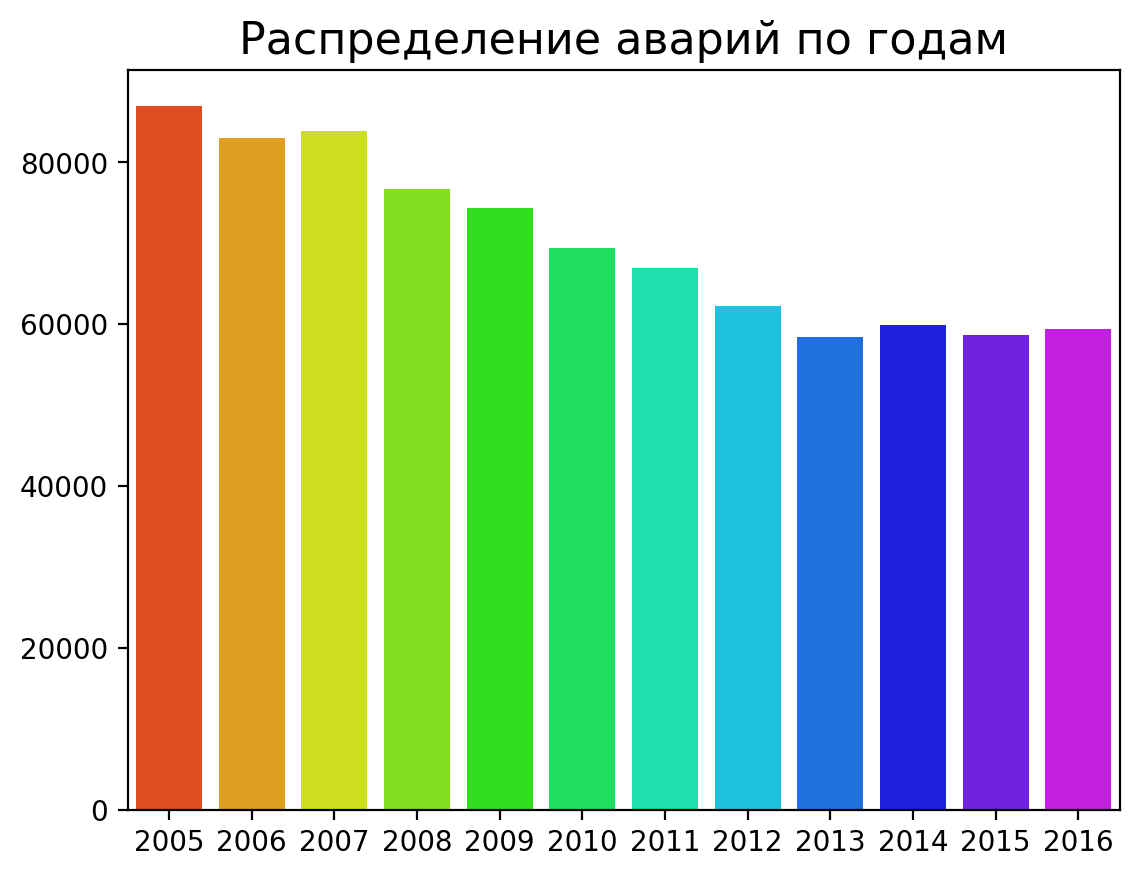

In [10]:
plt.title('Распределение аварий по годам')
sns.barplot(x=year.index, y=year.values, palette='gist_rainbow')
plt.xlabel('')
plt.savefig('d_years.png', dpi=128)

Начиная с 2013 года, число аварий перестало уменьшаться и вышло на некоторое плато.
Попробуем построить более развернутую зависимость, посмотрим на число аварий в течении года по месяцам

In [11]:
time_scale = char.groupby(by=['an', 'mois'])["Num_Acc"].count()
time_scale = time_scale.reset_index()

In [12]:
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

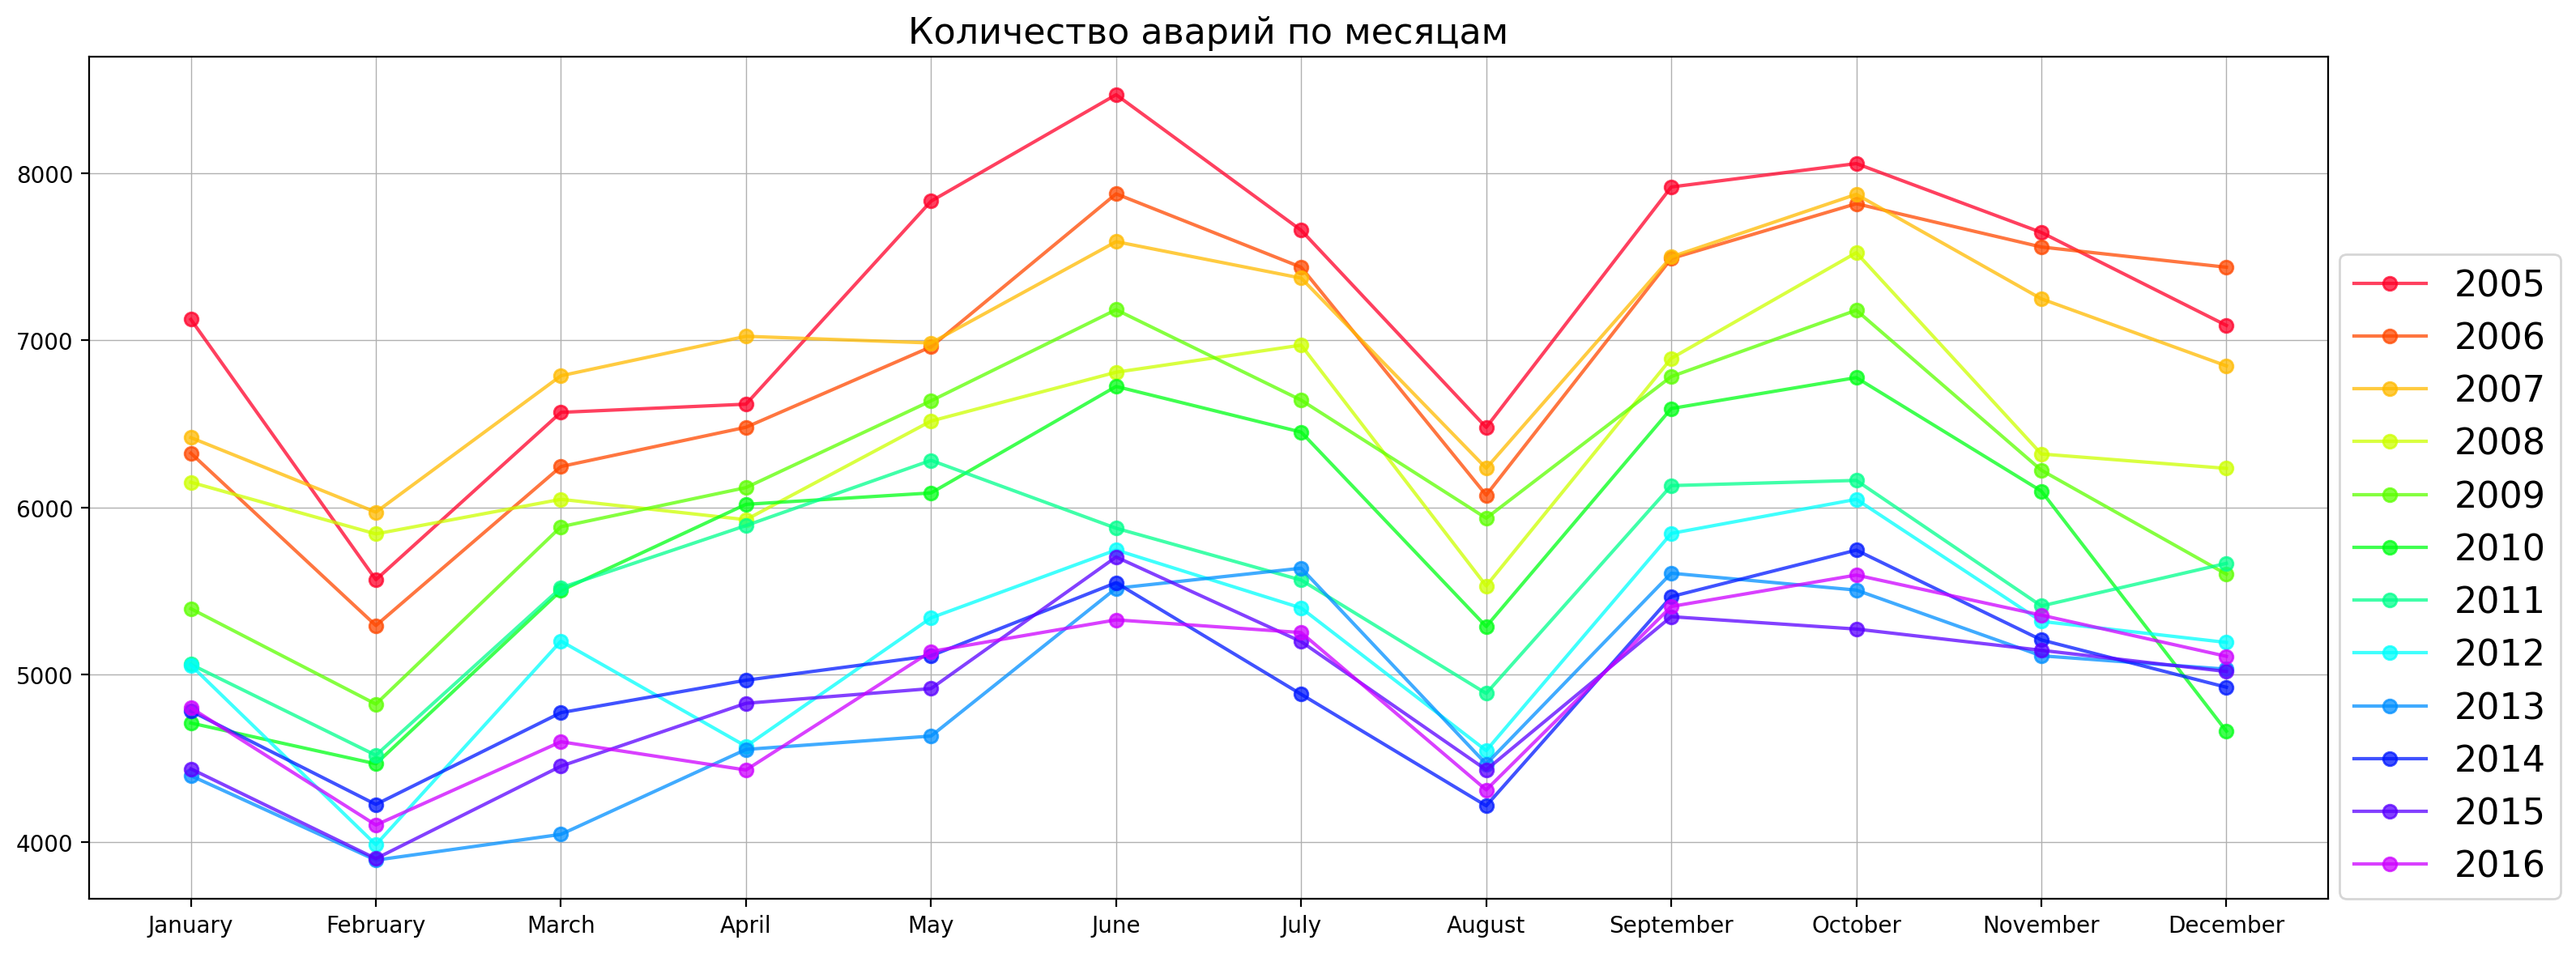

In [13]:
plt.figure(figsize=(16, 6))
plt.grid('--', lw=0.5, )
plt.title('Количество аварий по месяцам')
cm = plt.get_cmap('gist_rainbow')
unique_year = time_scale.an.unique()

for num, year in enumerate(unique_year):
    plt.plot(time_scale.loc[time_scale.an == year, 'mois'], time_scale.loc[time_scale.an == year, 'Num_Acc'], 
             marker='o',
             label=year,
             color=cm(num / len(unique_year)), alpha=0.75
            )
_ = plt.xticks(range(1, 13), labels=month)
plt.legend(loc=(1.005, 0.0))
plt.tight_layout()
plt.savefig('d_month.png', dpi=128)

Пики по числу аварий из года в год приходятся на Июнь и Октябрь. Также из года в год этот пик уменьшается. Помимо этого видно, что уменьшается не только всплески аварий, но все кривые с 2005 по 2013 год постепенно снижаются. Похоже на то, что в этот период вводились какие-то поправки в правила. Но вначале проверим приходятся ли всплекси аварий во времена праздников

Разобьем столбец с датой празника на год, месяц и день, чтобы было удонее искать праздники

In [14]:
holidays = pd.read_csv('data/holidays.csv')

holidays.ds = holidays.ds.apply(lambda x: datetime.datetime.strptime(str(x), '%Y-%m-%d'))

holidays['year'] = [i.year for i in holidays.ds]
holidays['month'] = [i.month for i in holidays.ds]
holidays['day'] = [i.day for i in holidays.ds]

In [15]:
holidays.head()

,ds,holiday,year,month,day
0,2005-01-01,New year,2005,1,1
1,2005-03-28,Easter Monday,2005,3,28
2,2005-05-01,Labour Day,2005,5,1
3,2005-05-05,Ascension Thursday,2005,5,5
4,2005-05-08,Victory in Europe Day,2005,5,8


Сгруппируем по месяцам - посмотрим на общее количество праздников за все года по месяцам

In [16]:
hol_dist = holidays.groupby(by=['month'], as_index=False)['holiday'].count()

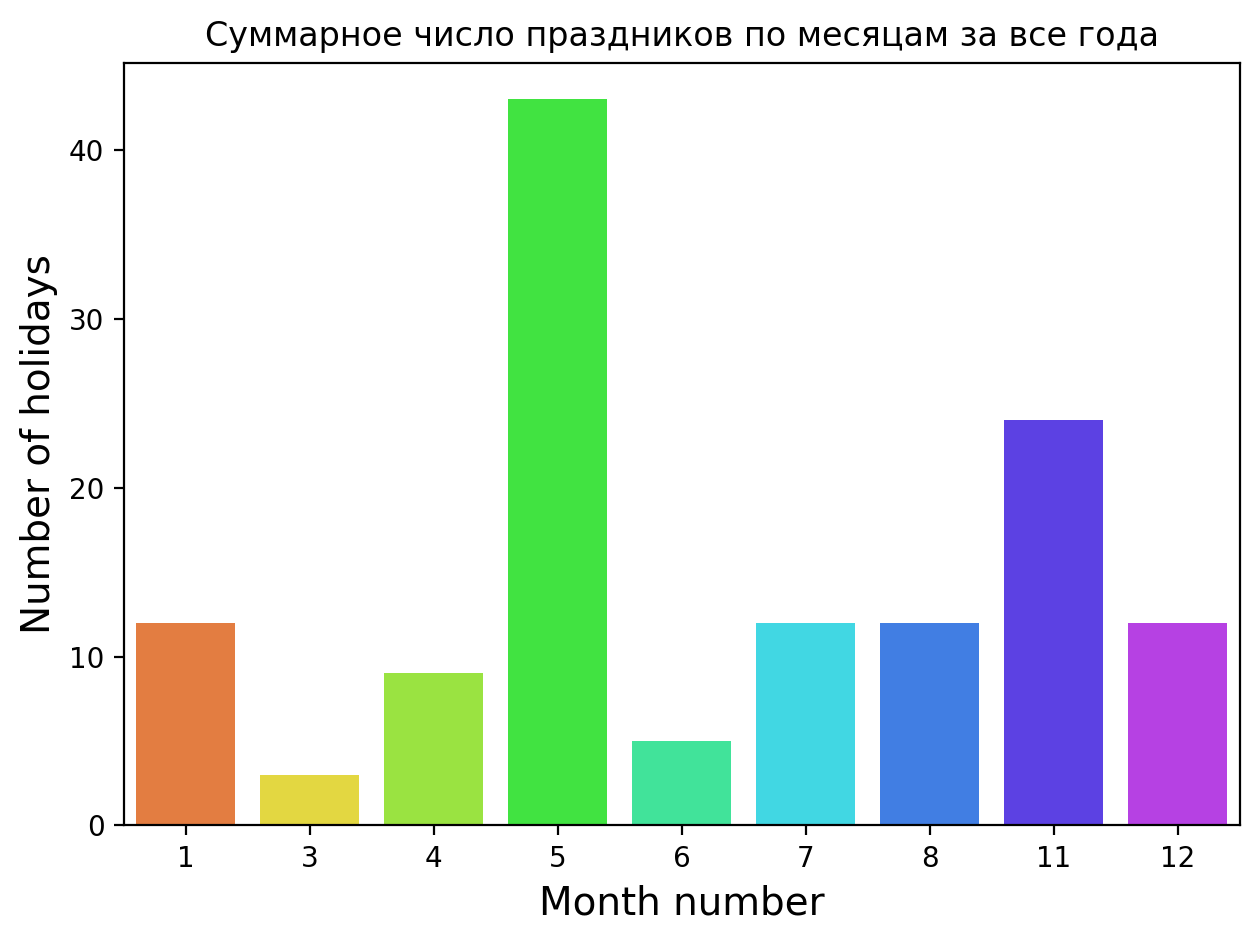

In [17]:
sns.barplot(x=hol_dist.month, y=hol_dist.holiday, palette='gist_rainbow', alpha=0.85)
plt.title('Суммарное число праздников по месяцам за все года', fontsize=12)
plt.xlabel('Month number', fontsize=14)
plt.ylabel('Number of holidays', fontsize=14)
plt.tight_layout()
plt.savefig('holy.png', dpi=128)

Как видно, совсем нет) В октябре праздников совсем нет, а июне за все эти года было 4 праздника

Итак, очень похоже, что с праздниками число аварий сильно не связано, так как всплески по числу аварий не приходятся на месяца с наибольшим их количеством. 

Попробуем разбить данные по возрастным группам. Посмотрим сначала на число аварий в этих группах за все время, а затем как эта величина менялась с течением времени. Для этого расчитаем возраст человека на момент аварии

In [18]:
# Сделаем отдельную колонку с годом аварии
users['crash_year'] = users.Num_Acc.apply(lambda x: int(str(x)[:4]))

# Вычисляем возраст на момент дтп
users['age'] = np.abs(users['crash_year'] - users['an_nais'])

# Разбиваем на возрастные группы
users['dang_age'] = np.where(users['age'] < 18  ,'<18',
                             np.where((users['age'] <= 26) & (users['age'] >= 18),'18-26',
                             np.where((users['age'] <= 35) & (users['age'] >= 27),'27-35',
                             np.where((users['age'] <= 45) & (users['age'] >= 36),'36-45',
                             np.where((users['age'] <= 60) & (users['age'] >= 46),'46-60','>60')))))

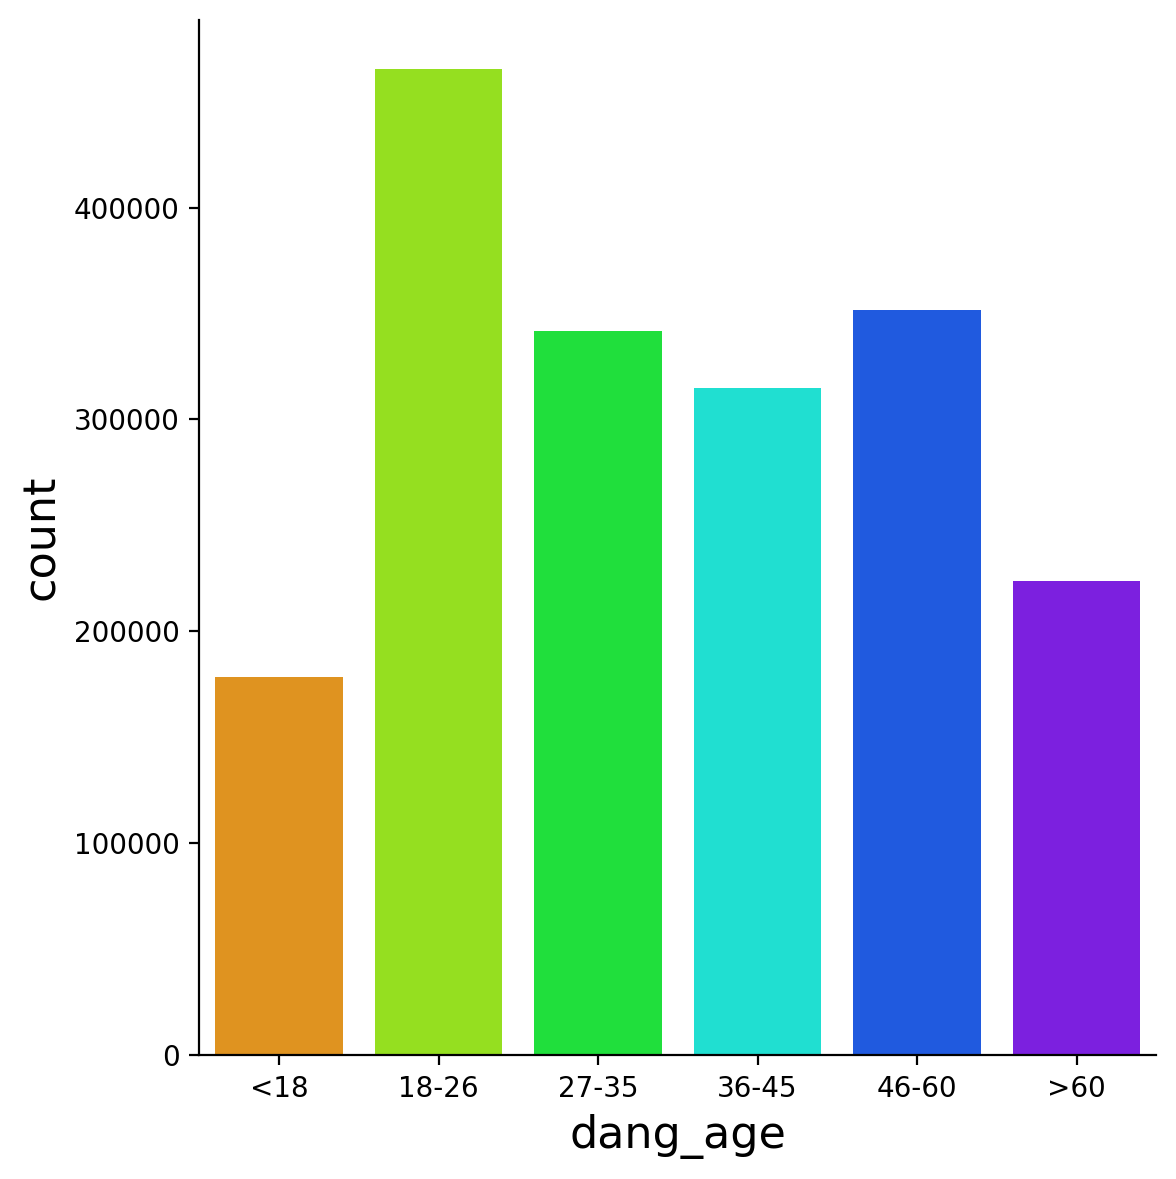

In [19]:
ages = ['<18', '18-26', '27-35', '36-45', '46-60', '>60']
sns.catplot(x="dang_age",  kind="count", data=users, height=6, order=ages, palette='gist_rainbow')

Так выглядит распределение числа аварий по выделенным возрастным группам за все года одновременно. По выделенным мной группам можно сказать, что чаще всего в аварии попадают молодые водители. 

Теперь построим динамику изменений числа аварий с учетом возрастных групп

In [20]:
time_years = users.groupby(by=['crash_year', 'dang_age'], as_index=False, )['Num_Acc'].count()

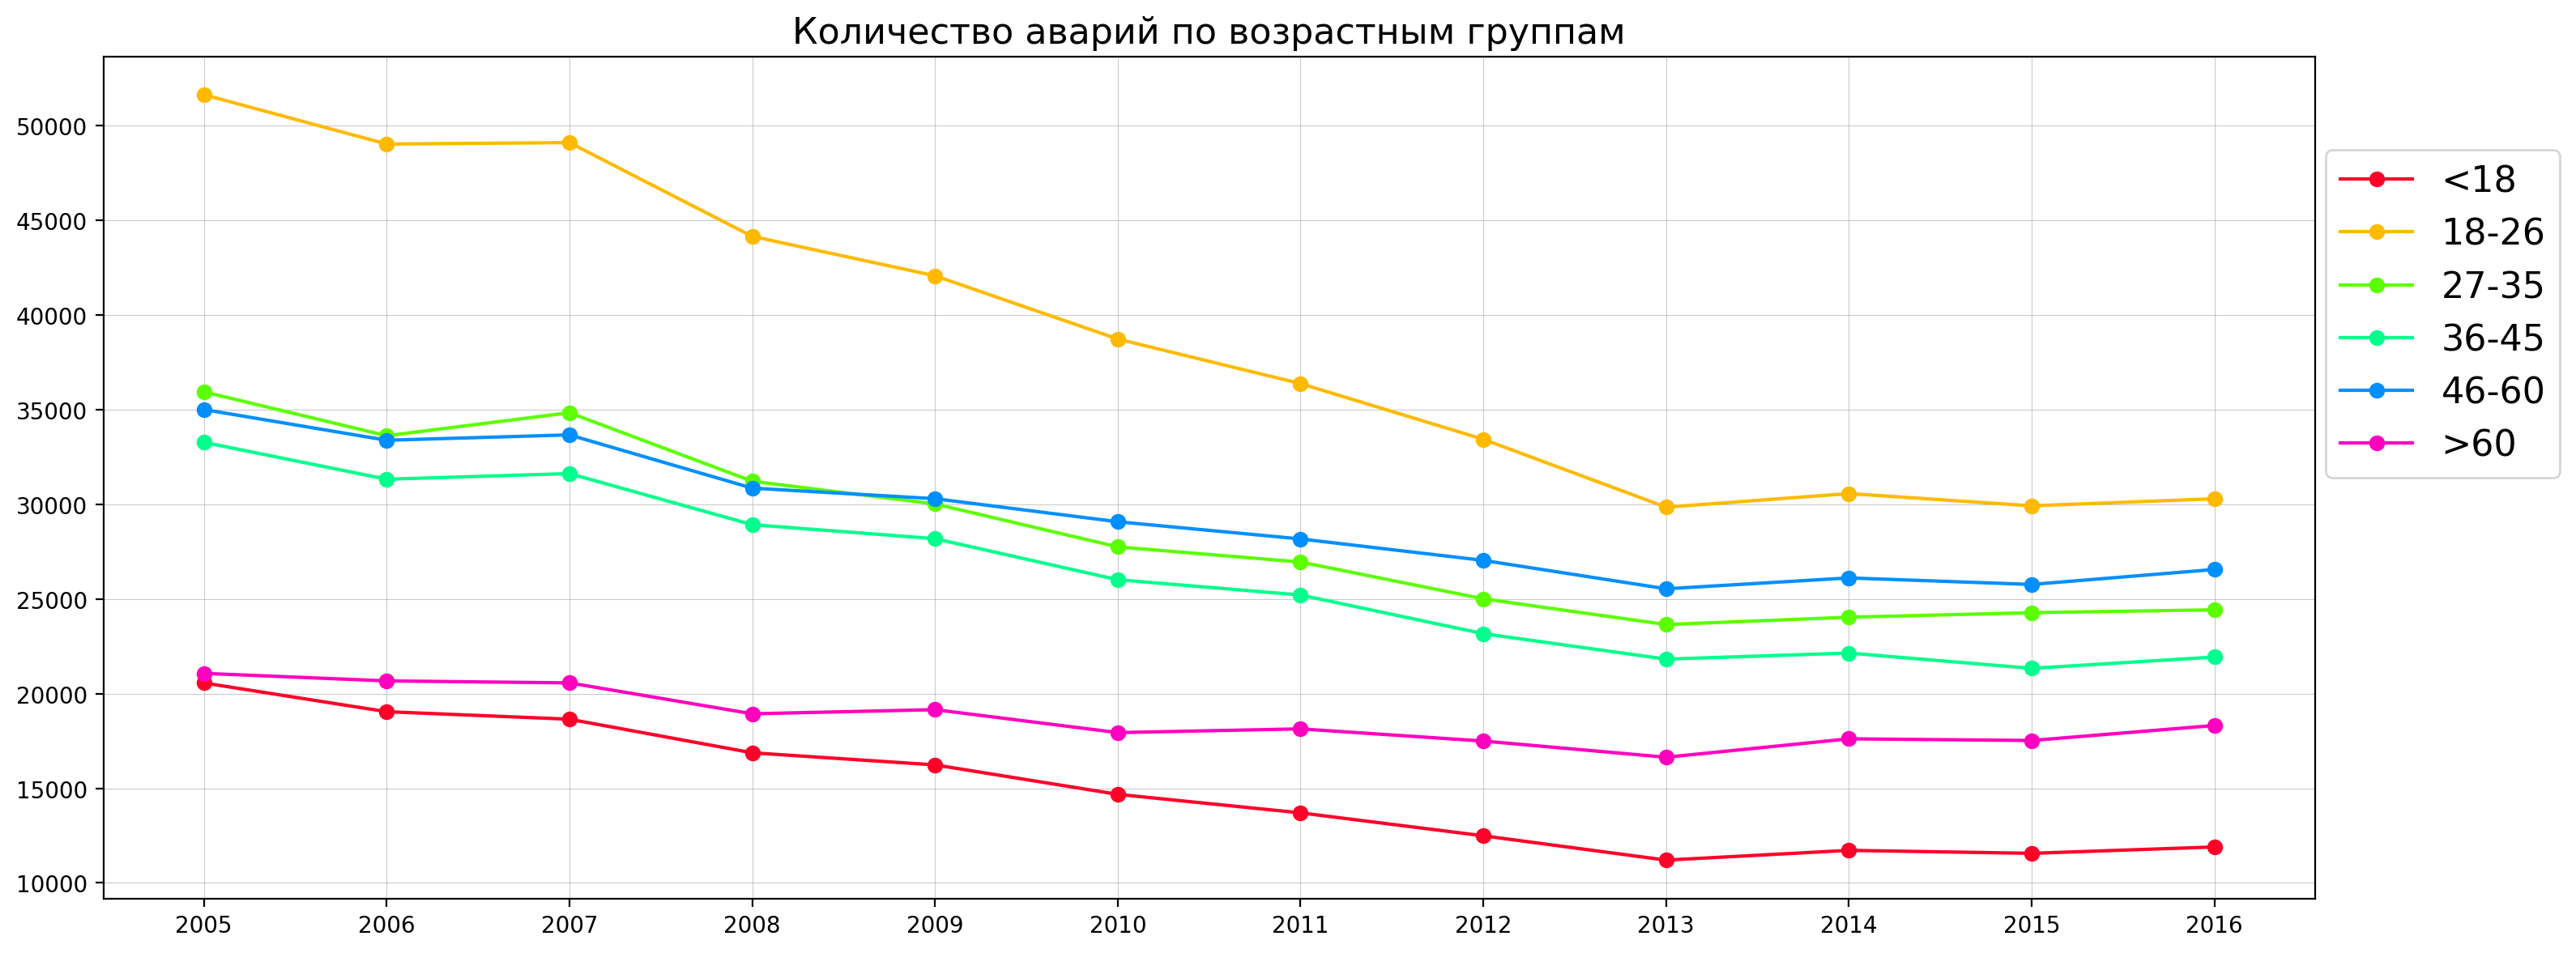

In [21]:
plt.figure(figsize=(16, 6))
plt.grid('--', lw=0.25, )
plt.title('Количество аварий по возрастным группам')
cm = plt.get_cmap('gist_rainbow')

for num, age in enumerate(ages):
    plt.plot(time_years.loc[time_years.dang_age == age, 'crash_year'], time_years.loc[time_years.dang_age == age, 'Num_Acc'], 
             marker='o',
             label=age,
             color=cm(num / (1 + len(age)))
            )
_ = plt.xticks(unique_year)
plt.legend(loc=(1.005, 0.5))
plt.tight_layout()
plt.savefig('d_group.png', dpi=128)

Тут тоже видно, снижение числа аварий практически для всех групп, поэтому стоит проверить идею о том, что действительно во Франции были предприняты какие-то меры по сокращению числа аварий. 

И на самом деле одно [издательств](https://rg.ru/amp/2008/07/21/dtp-zarubezh.html) утверждает, что
>в 2002 году президент Жак Ширак заявил, что одним из приоритетов его второго срока будет дорожная безопасность.

Статья опубликована на 2008 год, и там утверждается, что реформа прошла успешно. Ну вот мы и проверим их утверждение.
Итак, в качестве гипотезы выберем следующее утверждение

#### **Число аварий за период 2005 по 2008 значительно снизилось**

### Классификация объекта исследования и методы исследования. Проверка гипотезы

Идея исследования будет заключаться в том, чтобы составить из данных две выборки, например, число аварий на определенный возраст. В качестве опорных точек возьмем 2005 и 2008 года. Таким образом, будем иметь две независимые пространственные выборки. Здесь, несмотря на то, что мы зафиксировали результаты в конкретный момент времени. Мне кажется, что мы имеем дело именно с пространственной выборкой, так как мы берем непосредственно два измерения одной величины, для одной из которых был проведен эксперимент

In [22]:
data = users.loc[(users.crash_year == 2005) | (users.crash_year == 2008), ['Num_Acc', 'age', 'dang_age', 'crash_year']]
group_data = data.groupby(by=['age', 'dang_age', 'crash_year'], as_index=False).count()

/Users/xela/anaconda3/envs/yp_ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/xela/anaconda3/envs/yp_ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


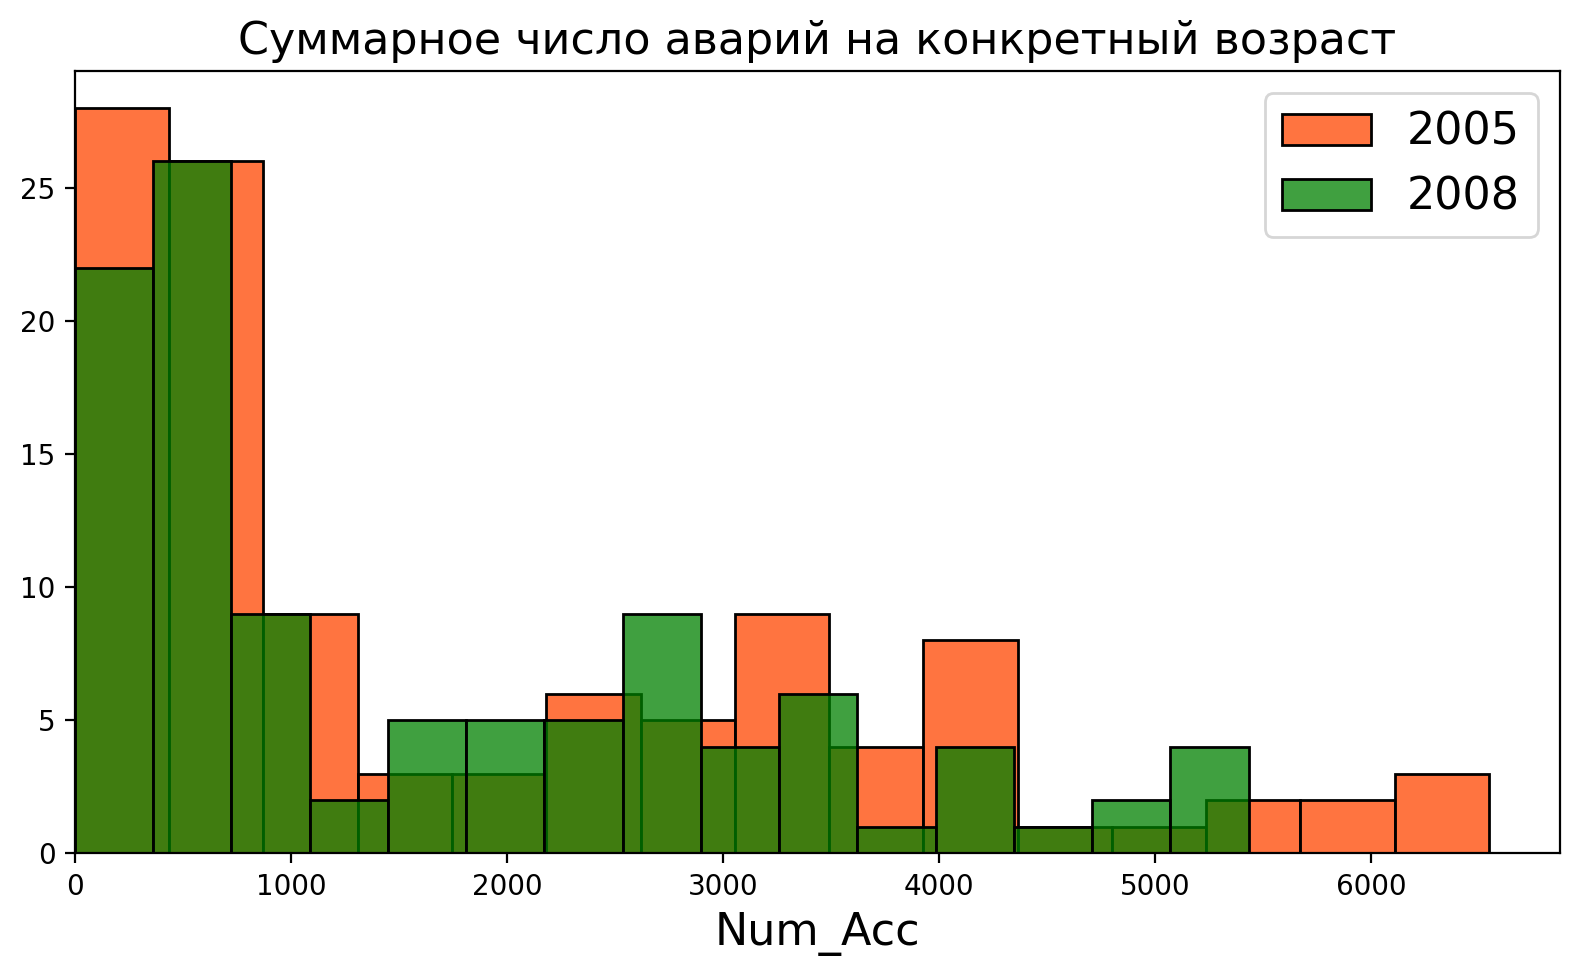

In [28]:
plt.figure(figsize=(8, 5))
sns.histplot(group_data.loc[group_data.crash_year == 2005].Num_Acc, bins=15, color='orangered')
sns.histplot(group_data.loc[group_data.crash_year == 2008].Num_Acc, bins=15, color='green')
plt.xlim(0)
plt.title('Суммарное число аварий на конкретный возраст')

plt.ylabel('')
plt.tight_layout()
plt.legend([2005, 2008])
# plt.savefig('acc_per_age.png', dpi=128)

Распределения представляются мне похожими, но они оказались даже визуально далеки от нормального, поэтому попробуем применить метод bootstrapp и центральную предельную теорему для выделения подвыборок из наших распределений близких к нормальному.

Сразу сделаем функцию, которая будет возвращать нам сгенерированные выборки, чтобы потом использовать ее и для получения распределений по группам

In [29]:
def get_ab_bs_distribution(arrays, stat_func, **kwargs):
    bs_data_a = bs.bootstrap(values=arrays[0], stat_func=stat_func, **kwargs)
    bs_data_b = bs.bootstrap(values=arrays[1], stat_func=stat_func, **kwargs)
    return bs_data_a, bs_data_b

In [35]:
ar1 = group_data.loc[group_data.crash_year == 2005, 'Num_Acc'].values
ar2 = group_data.loc[group_data.crash_year == 2008, 'Num_Acc'].values

data_2005, data_2008 = get_ab_bs_distribution((ar1, ar2), 
                                              stat_func=bs_stats.mean,
                                              num_iterations=2000,
                                              iteration_batch_size=15,
                                              return_distribution=True,
                                              num_threads=4, 
                                             )

/Users/xela/anaconda3/envs/yp_ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/xela/anaconda3/envs/yp_ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


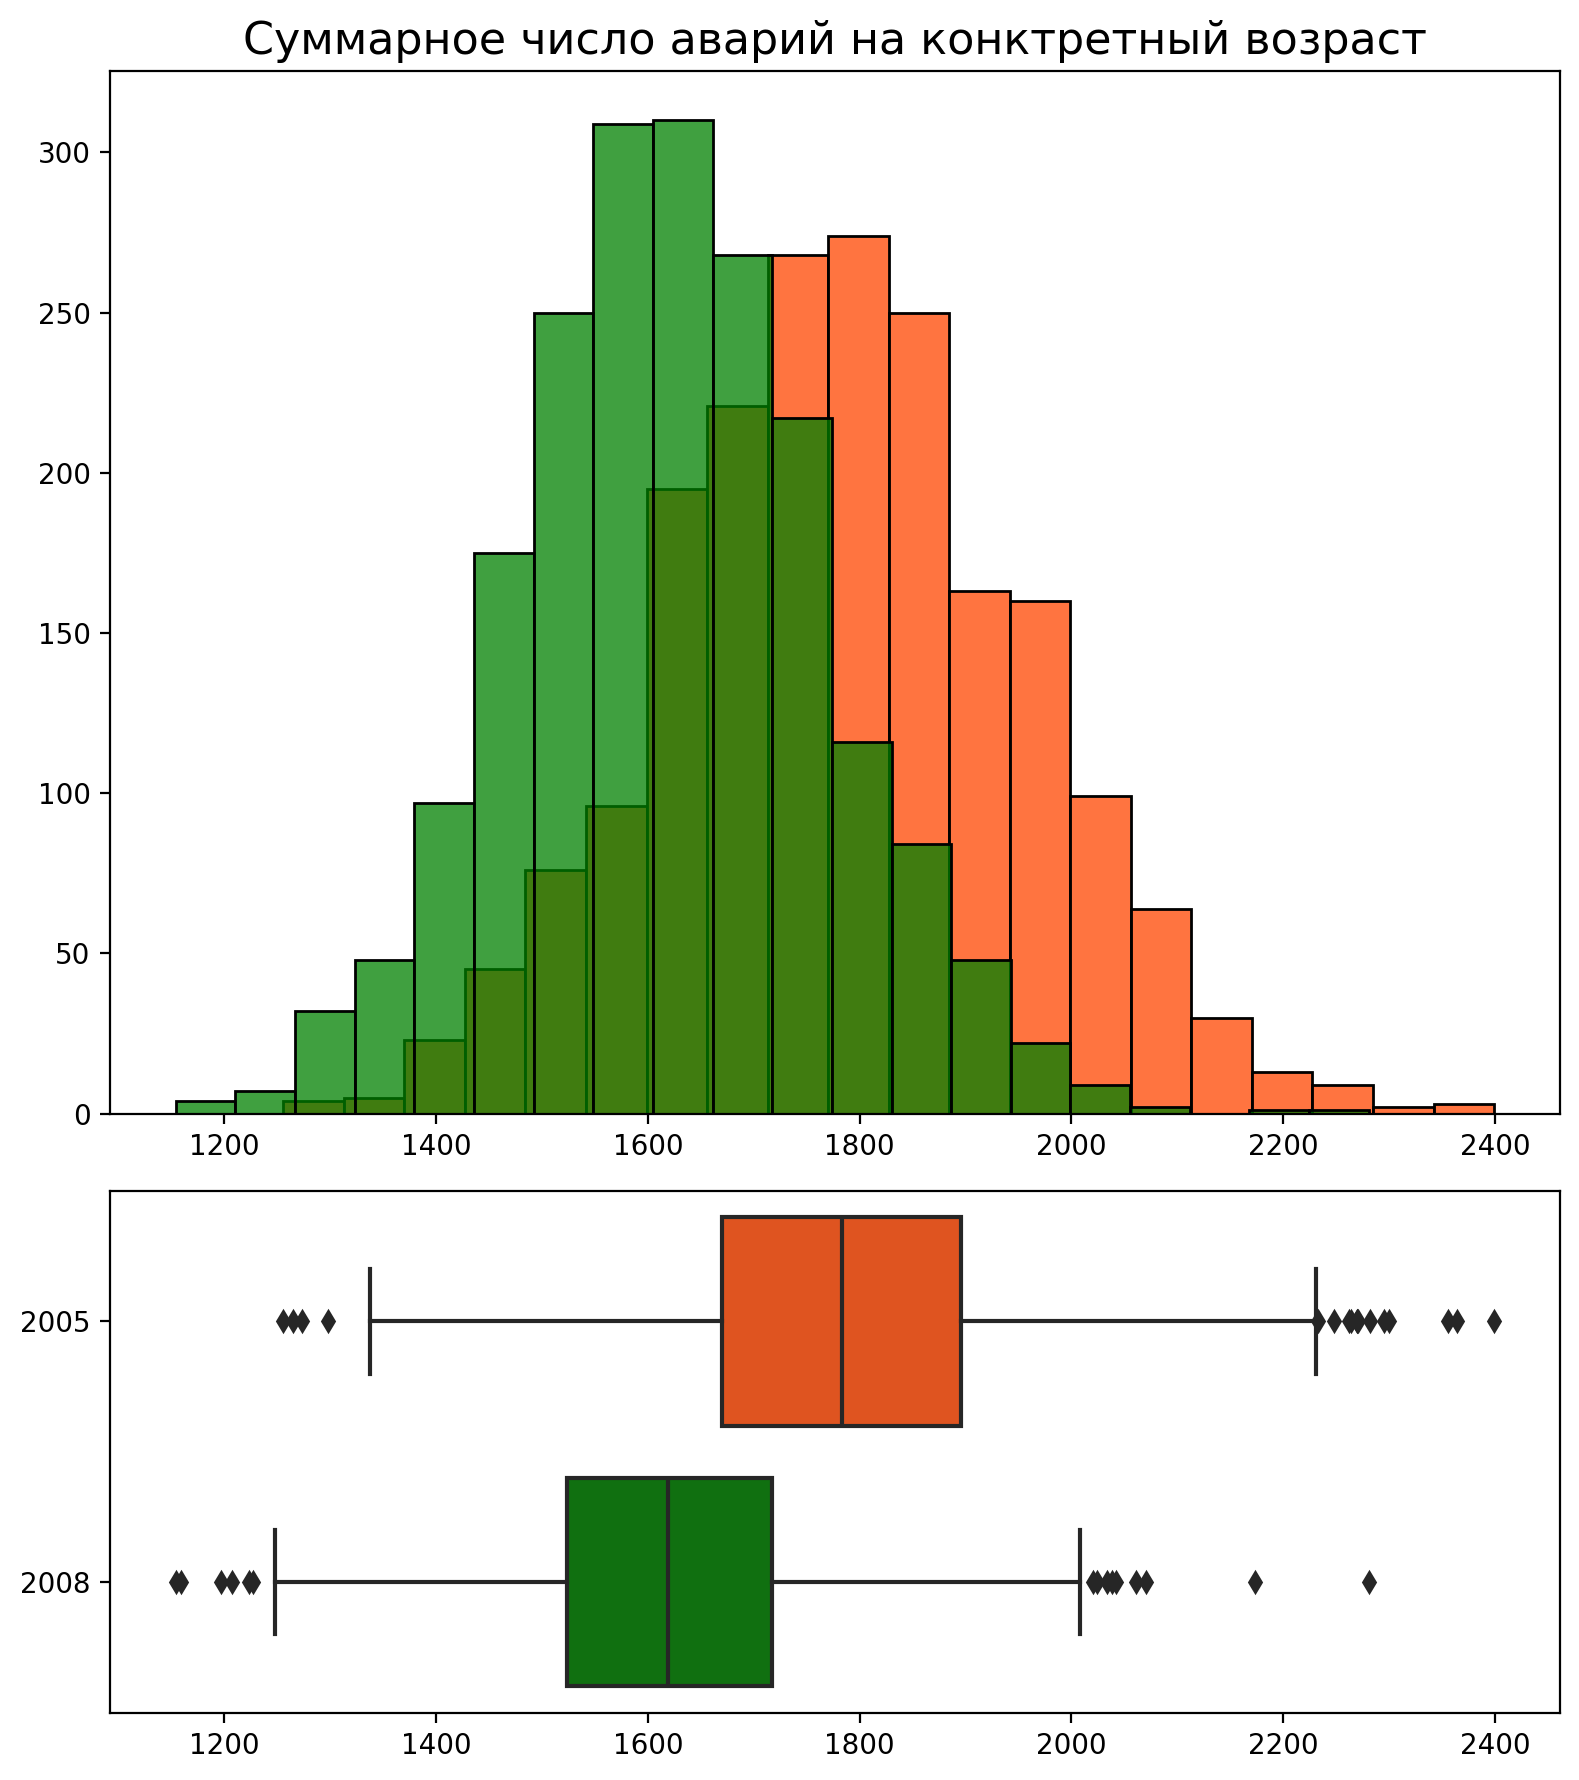

In [38]:
plt.figure(figsize=(8, 9), tight_layout=True)

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
plt.subplot(gs[0])
sns.histplot(data_2005, bins=20, color='orangered')
sns.histplot(data_2008, bins=20, color='green')
plt.title('Суммарное число аварий на конктретный возраст')
plt.ylabel('')

plt.subplot(gs[1])
sns.boxplot(data=[data_2005, data_2008], orient='h', palette=['orangered', 'green'])
plt.yticks([0, 1], [2005, 2008]);
# plt.savefig('bs_acc_per_age.png', dpi=128)


##### После бутстрапирования наши распределения выглядят похожими на нормальное распределение

Проверим это с помощью теста Шапиро-Уилка, так как число элементов в изначальной выборке небольшое. И сразу сделаем еще один визуальный тест, построив qq-plot для каждой из выборок

In [40]:
st = shapiro(data_2005)
alpha = 0.05
print('shapiro Group 2005 Distributions is {}normal'.format( {True:'', False:'not '}[st[1] >= alpha]))

st = shapiro(data_2008)
print('shapiro Group 2008 Distributions is {}normal'.format( {True:'', False:'not '}[st[1] >= alpha]))

shapiro Group 2005 Distributions is normal
shapiro Group 2008 Distributions is normal


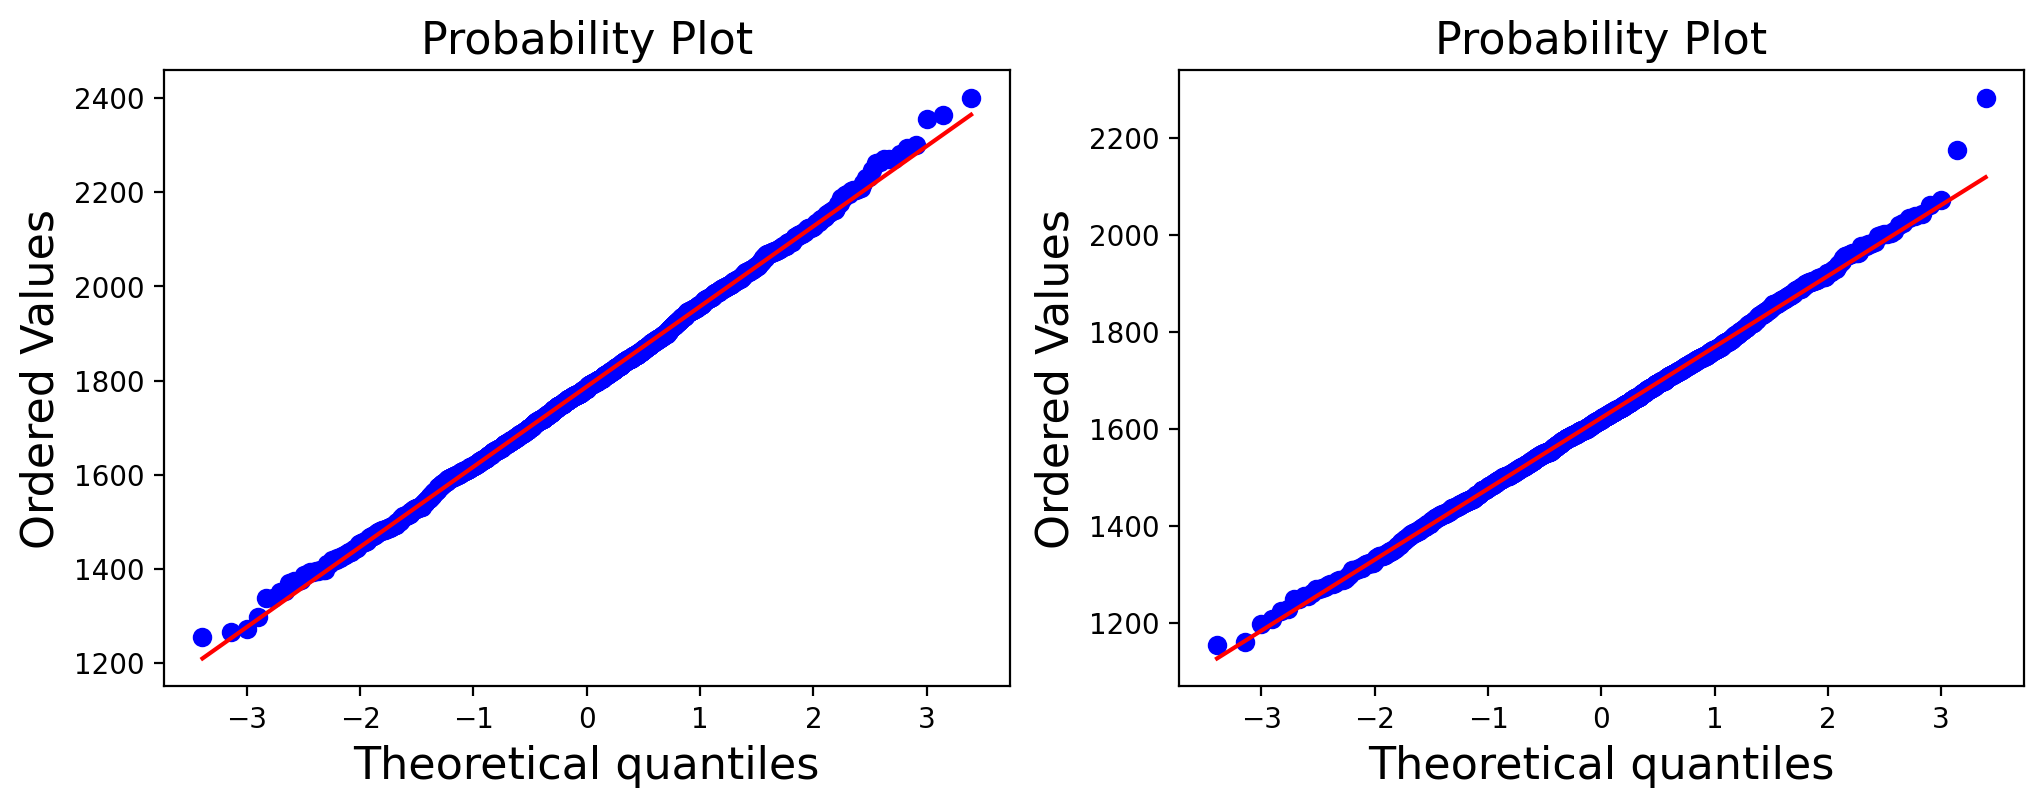

In [41]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
_ = stats.probplot(data_2005, dist="norm", plot=plt, )

plt.subplot(122)
_ = stats.probplot(data_2008, dist="norm", plot=plt)


Тут немного расстраивают хвосты распределений, но тест показал, что, несмотря на эти отклонения, можно считать распределения нормальными. Следовательно, для сравнения дисперсий и проверки стат значимости можно использовать F-критерий Фишера

In [45]:
a_value = 0.05
st, p_value = f_oneway(data_2005, data_2008)
print('F-Fisher: variances of distributions is {}equal\n'.format( {True:'', False:'not '}[p_value >= a_value]))

F-Fisher: variances of distributions is not equal



Раз дисперсии не равны, то применим критерий Манна Уитни, который не требует выполнения этого условия 

In [46]:
a_value = 0.05
stat, p_value = mannwhitneyu(data_2005, data_2008)
print('Mannwhitneyu: diffs is {}significant\n'.format( {True:'not ', False:''}[p_value >= a_value]))

Mannwhitneyu: diffs is significant



In [47]:
a_value = 0.05
stat, p_value = ttest_ind(data_2005, data_2008, equal_var=False)
print("Welch's t-test: diffs is {}significant\n".format( {True:'not ', False:''}[p_value >= a_value]))

Welch's t-test: diffs is significant



Наш тест показывает, что изменения имеют стат значимость, осталось проверить насколько можно доверять этому результату.
Для этого оценим объем нашей выборки

In [48]:
mean_a = data_2005.mean()
std_a = data_2005.std()
mean_b = data_2008.mean()
std_b = data_2008.std()

effect = np.abs(mean_a - mean_b) / std_a
ratio = data_2008.shape[0] / data_2005.shape[0]

In [51]:
analysis = TTestIndPower()
result = analysis.solve_power(effect, alpha=0.01, power=0.999, ratio=ratio,)# nobs1=group_A.shape[0])

In [52]:
print(f'Sample Size: {result:.3f}')

Sample Size: 69.844


Итак, наш тест показал, что нашего размера выборки достаточно, чтобы доверять проведенным тестам. Таким образом, проведенная во Франции мера по ужесточению штрафов за нарушения ППД привела к значимому результату.

Мы определили, что реформа в целом сработала для населения. Однако, также интересно взглянуть насколько она повлияна на конкретные возрастные группы

In [53]:
print(f"Decrease: {1 - data_2008.mean() / data_2005.mean(): ^5.1%}")

Decrease: 9.2% 


/Users/xela/anaconda3/envs/yp_ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/xela/anaconda3/envs/yp_ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/xela/anaconda3/envs/yp_ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/xela/anaconda3/envs/yp_ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

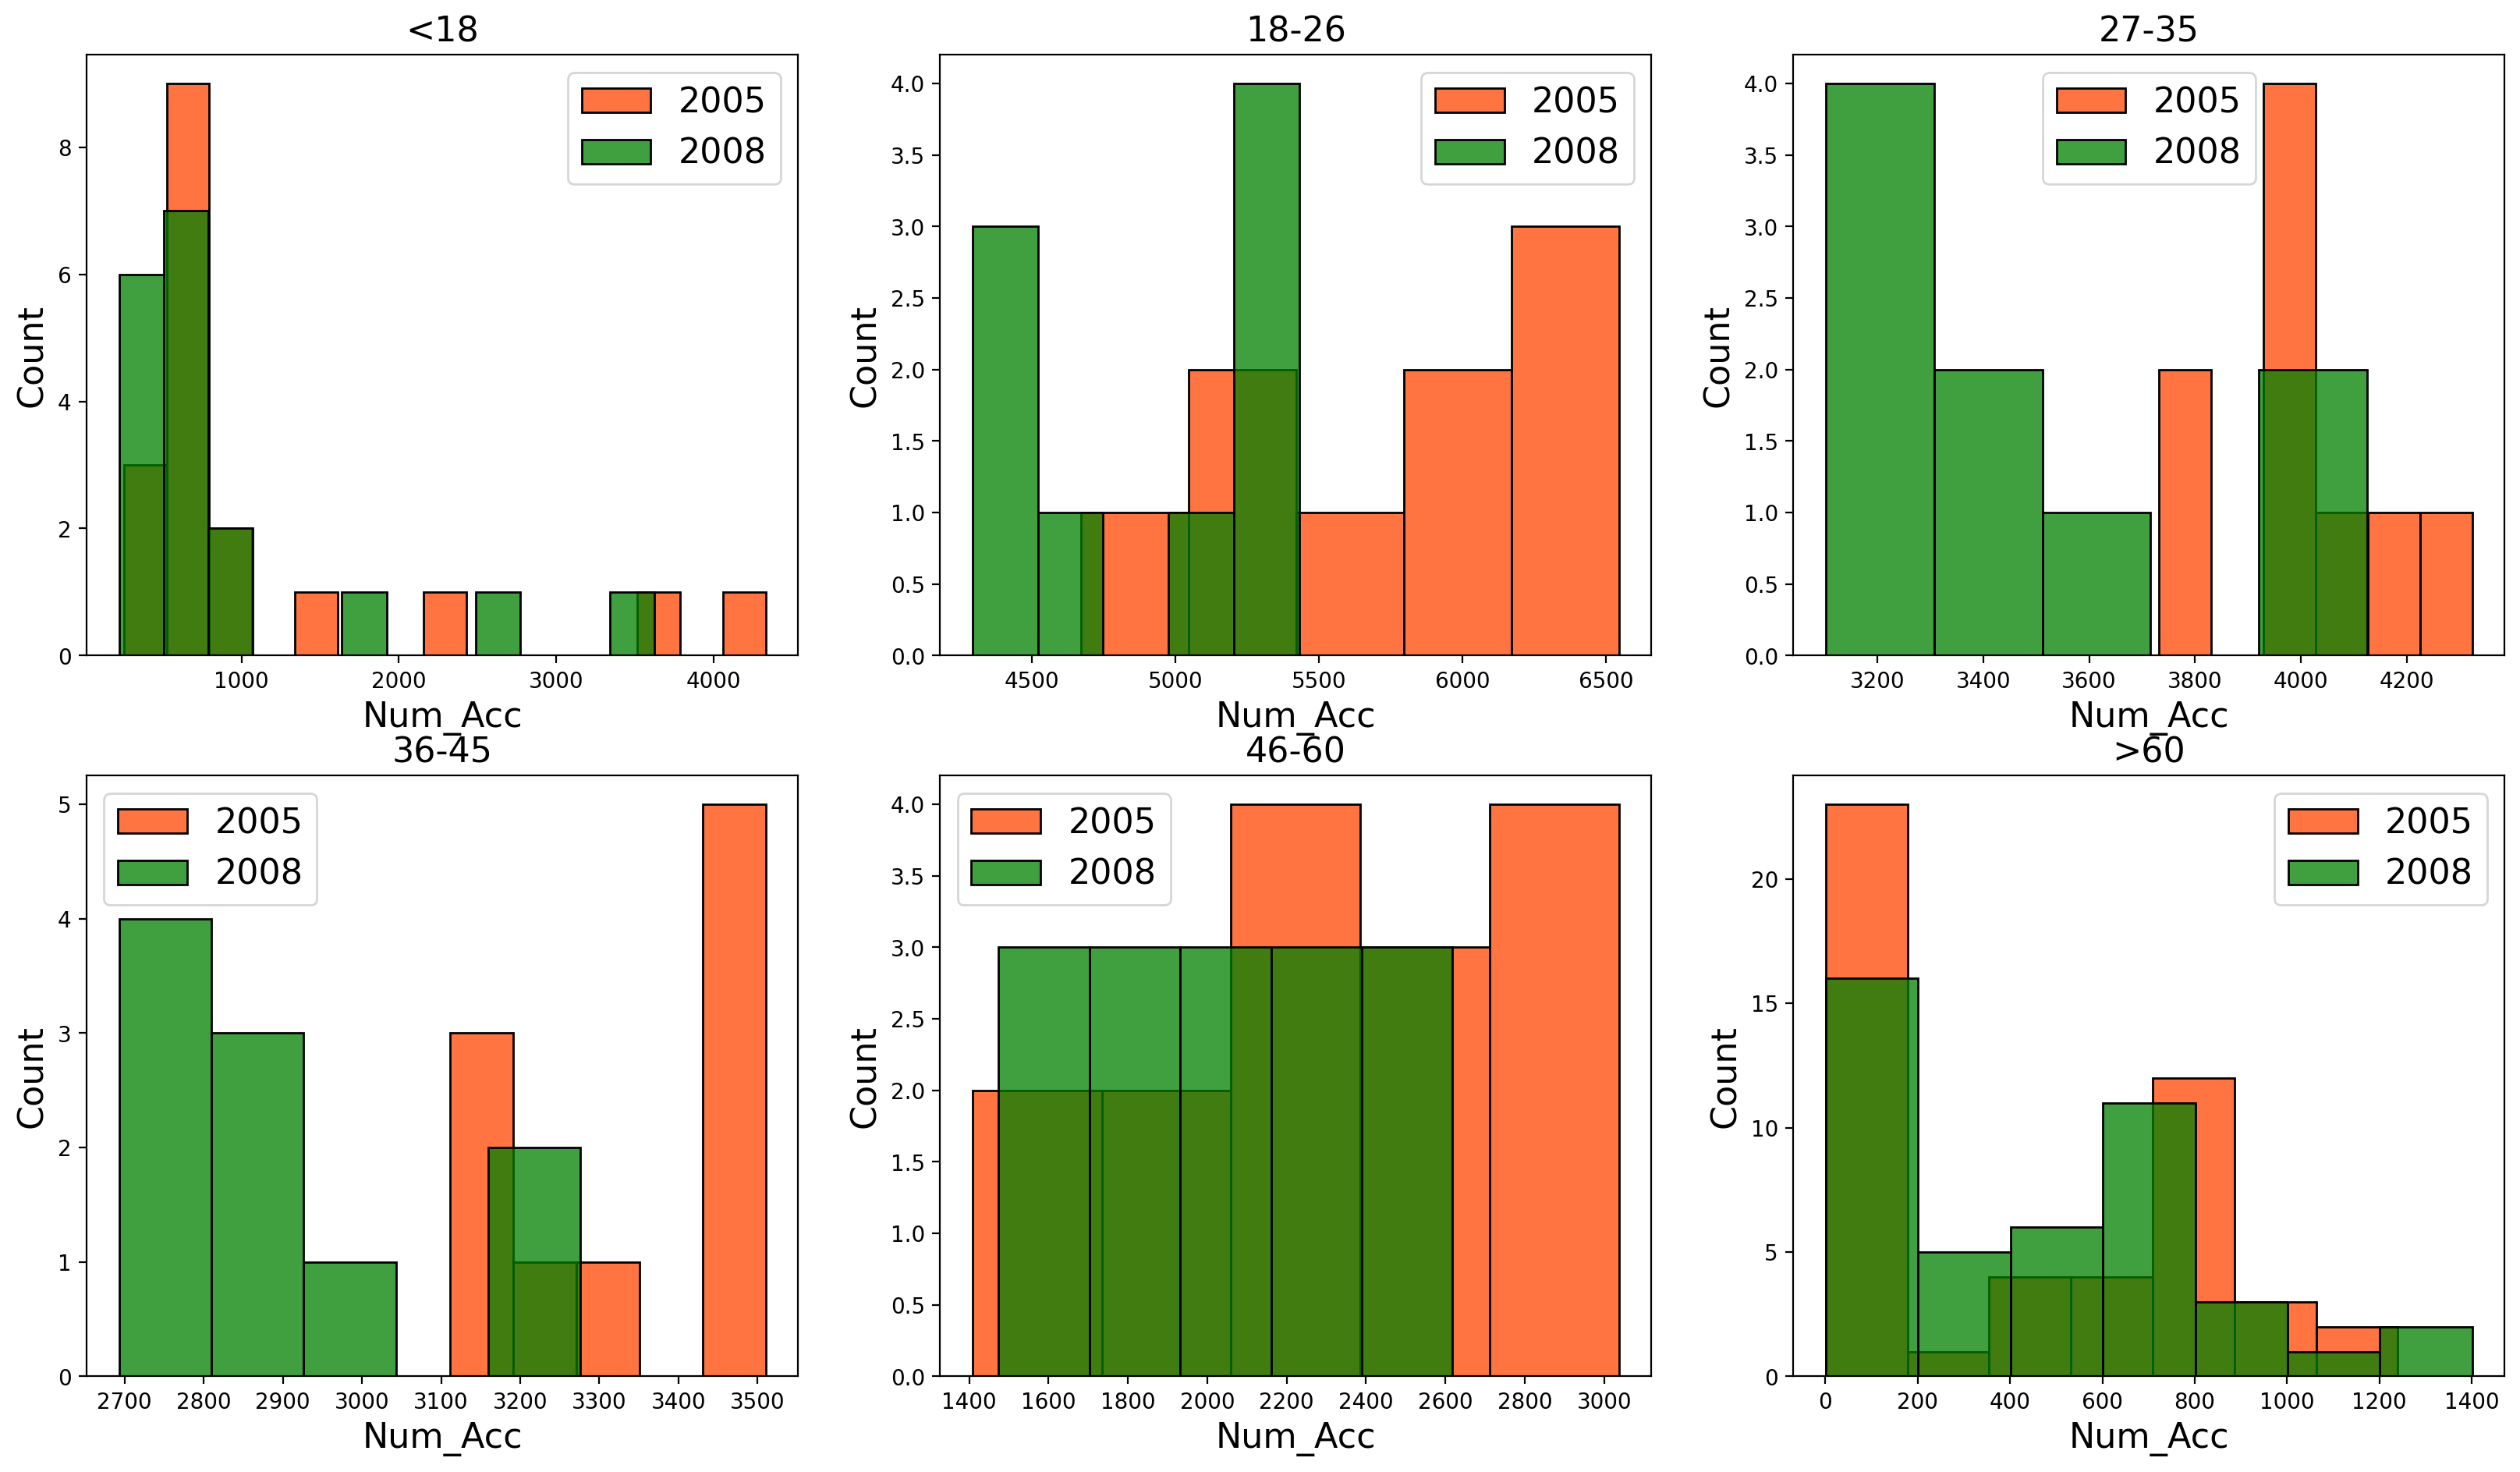

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(20, 11))
for group, ax in zip(ages, axes.flatten()):
    sns.histplot(group_data.loc[(group_data.dang_age == group) & (group_data.crash_year == 2005), 'Num_Acc'], color='orangered', kde=False, ax=ax)
    sns.histplot(group_data.loc[(group_data.dang_age == group) & (group_data.crash_year == 2008), 'Num_Acc'], color='green', kde=False, ax=ax)
    ax.set_title(group)
    ax.legend([2005, 2008])

Далее, снова проделаем ту же схему как и при без разделения на группы

In [56]:
data_2005 = []
data_2008 = []

for group in ages:
    ar1 = group_data.loc[(group_data.dang_age == group) & (group_data.crash_year == 2005), 'Num_Acc'].values
    ar2 = group_data.loc[(group_data.dang_age == group) & (group_data.crash_year == 2008), 'Num_Acc'].values

    a, b = get_ab_bs_distribution((ar1, ar2), 
                                  stat_func=bs_stats.mean,
                                  num_iterations=4000,
                                  iteration_batch_size=10,
                                  return_distribution=True,
                                  num_threads=4
                                 )
    data_2005.append(a)
    data_2008.append(b)

/Users/xela/anaconda3/envs/yp_ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/xela/anaconda3/envs/yp_ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/xela/anaconda3/envs/yp_ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/xela/anaconda3/envs/yp_ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

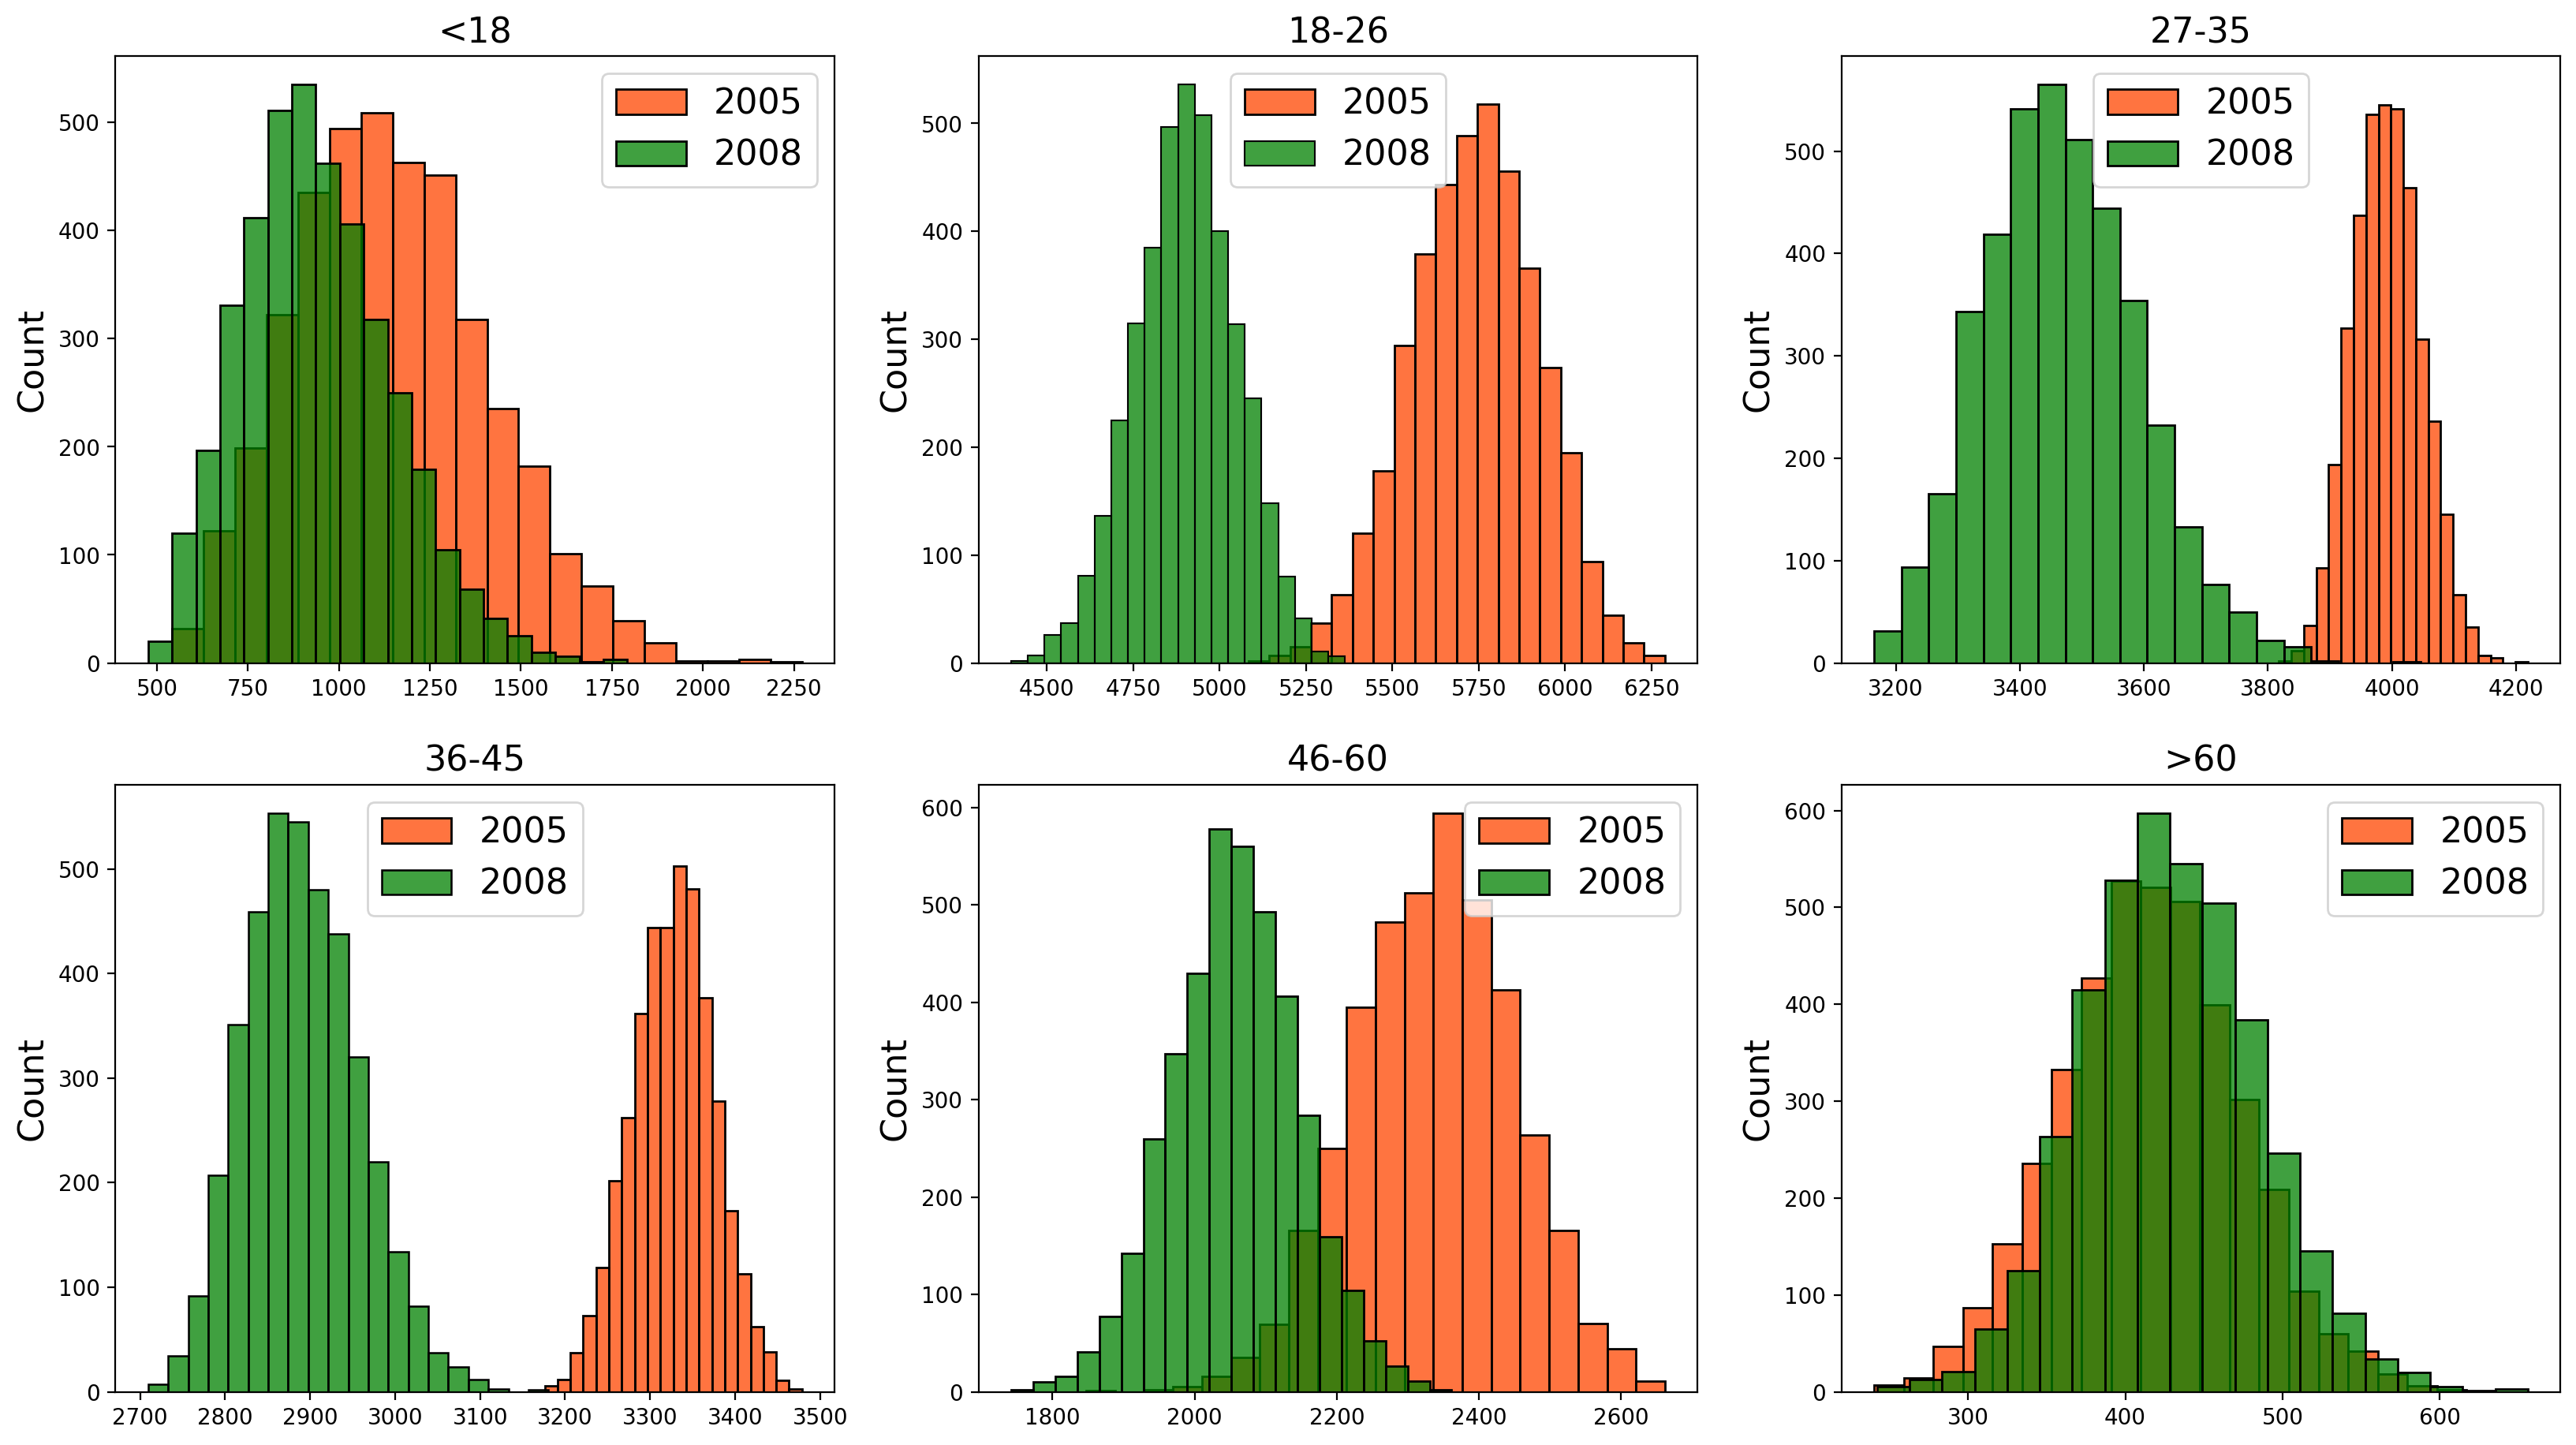

In [60]:
fig, axes = plt.subplots(2, 3, figsize=(20, 11))
for num, group, ax in zip(range(len(ages)), ages, axes.flatten()):
    sns.histplot(data_2005[num], bins=20, color='orangered', kde=False, ax=ax)
    sns.histplot(data_2008[num], bins=20, color='green', kde=False, ax=ax)
    ax.set_title(group)
    ax.legend([2005, 2008])

В итоге распределения хоть и стали напоминать нормальные, но все равно есть ощущение, что не до конца таковыми являются. Дальше, для наглядности будет записывать результаты проверок на нормальность и стат значимость в таблицу. 

In [61]:
group_stat = pd.DataFrame(columns=[f"{i}_{j}" for i in ages for j in ['A', 'B']], index=['Normality', 'Norm_test', 'Variance', 'Var_test', 'Significance', 'Sign_test'])

In [62]:
group_stat

,<18_A,<18_B,18-26_A,18-26_B,27-35_A,27-35_B,36-45_A,36-45_B,46-60_A,46-60_B,>60_A,>60_B
Normality,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Norm_test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Variance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Var_test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Significance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sign_test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Тесты где будут сравниваться две выборки запишем в столбец А

На нормальность проверяем тестом Шапиро Уилка, так как число элементов в выборке не так велико

In [63]:
alpha = 0.05
for num, d2005, d2008 in zip(range(len(data_2005)), data_2005, data_2008):
    st = shapiro(d2005)
    group_stat.iloc[0, 2*num] = 1 if st[1] >= alpha else 0  # 1 - normal; 0 - not normal
    group_stat.iloc[1, 2*num] = 'shapiro'
    
    st = shapiro(d2008)
    group_stat.iloc[0, 2*num+1] = 1 if st[1] >= alpha else 0  # 1 - normal; 0 - not normal
    group_stat.iloc[1, 2*num+1] = 'shapiro'

In [64]:
group_stat

,<18_A,<18_B,18-26_A,18-26_B,27-35_A,27-35_B,36-45_A,36-45_B,46-60_A,46-60_B,>60_A,>60_B
Normality,0,0,0,1,0,0,0,0,0,1,1,0
Norm_test,shapiro,shapiro,shapiro,shapiro,shapiro,shapiro,shapiro,shapiro,shapiro,shapiro,shapiro,shapiro
Variance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Var_test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Significance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sign_test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для оценки дисперсии будем применять критерий Фишера, если обе выборки распределены нормально и критерий Левена (он не требует номальности распределения) если же хоть одна из двух выборок . Аналогично для оценки стат знаичимости, в случае равенства нормальности распределений и равенства дисперсий будет применен критерий Стьюдента, в противном случае будет использован критерий Манна Уитни

Считаем равенство дисперсий

In [68]:
alpha = 0.05
for num, d2005, d2008 in zip(range(len(data_2005)), data_2005, data_2008):
    # Если обе выборки распределены нормально, то применяем F критерий Фишера
    if group_stat.iloc[0, 2*num] * group_stat.iloc[0, 2*num+1] == 1:
        st, p_value = f_oneway(d2005, d2008)
        group_stat.iloc[2, 2*num] = 1 if p_value >= a_value else 0  # 1 - variances are equal; 0 - not equal
        group_stat.iloc[3, 2*num] = 'F-fisher'
    # В противном случае критерий Левена
    else:
        st, p_value = levene(d2005, d2008)
        group_stat.iloc[2, 2*num] = 1 if p_value >= a_value else 0  # 1 - variances are equal; 0 - not equal
        group_stat.iloc[3, 2*num] = 'Levene'


Смотрим на стат значимость

In [69]:
alpha = 0.05
for num, d2005, d2008 in zip(range(len(data_2005)), data_2005, data_2008):
    # Если обе выборки распределены нормально и дисперсии равны, то применяем T критерий Cтьюдента
    if group_stat.iloc[0, 2*num] * group_stat.iloc[0, 2*num+1] * group_stat.iloc[2, 2*num] == 1:
        st, p_value = ttest_ind(d2005, d2008)
        group_stat.iloc[4, 2*num] = 0 if p_value >= a_value else 1  # 1 - diffs significant; 0 - diffs not significant
        group_stat.iloc[5, 2*num] = 't-student'
    # В противном случае критерий Манна Уитни
    else:
        st, p_value = mannwhitneyu(d2005, d2008)
        group_stat.iloc[4, 2*num] = 0 if p_value >= a_value else 1  # 1 - diffs significant; 0 - diffs not significant
        group_stat.iloc[5, 2*num] = 'Mann-Witney'


Итак, взглянем на результаты

In [70]:
group_stat

,<18_A,<18_B,18-26_A,18-26_B,27-35_A,27-35_B,36-45_A,36-45_B,46-60_A,46-60_B,>60_A,>60_B
Normality,0,0,0,1,0,0,0,0,0,1,1,0
Norm_test,shapiro,shapiro,shapiro,shapiro,shapiro,shapiro,shapiro,shapiro,shapiro,shapiro,shapiro,shapiro
Variance,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,1,NaN
Var_test,Levene,NaN,Levene,NaN,Levene,NaN,Levene,NaN,Levene,NaN,Levene,NaN
Significance,1,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,NaN
Sign_test,Mann-Witney,NaN,Mann-Witney,NaN,Mann-Witney,NaN,Mann-Witney,NaN,Mann-Witney,NaN,Mann-Witney,NaN


Получается, что во всех случаях для проверки стат значимости был применен тест Манна-Уитни и для всех возрастных групп результат оказался значимым. Значит, реформа оказалась действенной для всех возрастных групп (наверное по-другому не былвает, когда сильно поднимают штрафы). Послденее, что хочется сделать - это посмотреть на сколько процентов уменьшилось число аварий в целом по группе

In [71]:
for group, d05, d08 in zip(ages, data_2005, data_2008):
    print(f"Group: {group: ^10} {1- d08.mean() / d05.mean(): ^5.1%}")

Group:    <18     18.0%
Group:   18-26    14.5%
Group:   27-35    13.1%
Group:   36-45    13.1%
Group:   46-60    12.0%
Group:    >60     -3.1%


Забавно, получается, что насчет последней группы я оказался не прав. Выходит, что пожилое население Франции вопреки введенной реформе стали чаще нарушать правила и попадать в аварии